# Práctica 3

#### TAREA 1: Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedasW y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. 

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo. 

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import os

# --- 1) Preprocesamiento de imagen ---
def preprocesar_imagen(ruta_img, umbral=200):
    img = cv2.imread(ruta_img)
    img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, img_th = cv2.threshold(img_gris, umbral, 255, cv2.THRESH_BINARY_INV)
    return img, img_th

# --- 2) Detección de monedas ---
def detectar_monedas(img_th, area_min=200):
    contours, _ = cv2.findContours(img_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    coins = []
    for c in contours:
        if cv2.contourArea(c) < area_min:
            continue
        (cx, cy), r = cv2.minEnclosingCircle(c)
        coins.append({'center': (int(cx), int(cy)), 'r_px': r, 'contour': c})
    return coins

# --- 3) Selección de moneda de referencia mediante clic ---
def seleccionar_monedas_referencia(img, coins):
    coords = []
    
    def click(event, x, y, *_):
        if event == cv2.EVENT_LBUTTONDOWN:
            coords.append((x, y))
            cv2.destroyAllWindows()
    
    cv2.imshow("Clic en moneda de referencia", img)
    cv2.setMouseCallback("Clic en moneda de referencia", click)
    cv2.waitKey(0)
    
    if not coords: 
        return None, None
    
    x, y = coords[0]
    idx_ref = np.argmin([math.hypot(c['center'][0]-x, c['center'][1]-y) for c in coins])
    return coins[idx_ref], idx_ref

# --- 4) Obtener escala a partir de moneda de referencia ---
def calcular_escala(ref_coin, radios):
    try:
        valor_ref = float(input("Valor de la moneda clicada (ej: 1 para 1€, 0.1 para 1 cent): "))
    except:
        return None, None

    if valor_ref not in radios:
        return None, None
    
    escala = radios[valor_ref] / ref_coin['r_px']
    return escala, valor_ref

# --- 5) Clasificación de monedas ---
def clasificar_monedas(coins, escala, radios):
    total = 0
    results = []
    for c in coins:
        cx, cy, r_px = *c['center'], c['r_px']
        radio_mm = r_px * escala
        dists = {v: abs(radios[v] - radio_mm) for v in radios}
        asignado = min(dists, key=dists.get)
        total += asignado
        results.append({'center': (cx, cy), 'r_px': r_px, 'radio_mm': radio_mm, 'assigned': asignado})
    return total, results

# --- 6) Visualización y guardado ---
def mostrar_resultado(img, results, total, ruta_img):
    out = img.copy()
    for r in results:
        cx, cy, r_px, val = *r['center'], int(r['r_px']), r['assigned']
        cv2.circle(out, (cx, cy), r_px, (0, 255, 0), 2)
        cv2.putText(out, f"{val:.2f}", (cx-50, cy), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 2)

    nombre = os.path.splitext(os.path.basename(ruta_img))[0]
    plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Total: {total:.2f} €")
    os.makedirs("salidas", exist_ok=True)
    plt.savefig(f"salidas/{nombre}_resultado.jpg", dpi=300, bbox_inches="tight")
    plt.show()

# --- Función principal ---
def contar_monedas(ruta_img):
    radios = {0.01:8.125, 0.02:9.375, 0.05:10.625, 0.10:9.875, 0.20:11.125,
              0.50:12.125, 1.00:11.625, 2.00:12.875}

    img, img_th = preprocesar_imagen(ruta_img)
    coins = detectar_monedas(img_th)
    if not coins:
        print("⚠️ No se detectaron monedas.")
        return 0, []

    ref_coin, _ = seleccionar_monedas_referencia(img, coins)
    if ref_coin is None:
        return 0, coins

    escala, valor_ref = calcular_escala(ref_coin, radios)
    if escala is None:
        return 0, coins

    total, results = clasificar_monedas(coins, escala, radios)
    mostrar_resultado(img, results, total, ruta_img)
    return total, results



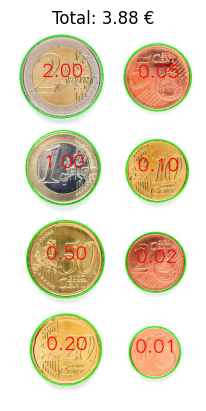

Total detectado: 3.88 €


In [27]:
total, resultados = contar_monedas("recursos/monedas_ideal.jpg")
print(f"Total detectado: {total:.2f} €")